<a href="https://colab.research.google.com/github/julia-e-ma/movies/blob/main/RandomMovieGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports and google drive authorization
from google.colab import auth
auth.authenticate_user()
import random
import pandas as pd
import gspread
from google.auth import default
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import matplotlib.pyplot as plt
import numpy as np
from google.colab import userdata
import urllib.request
import json
creds, _ = default()
gc = gspread.authorize(creds)
api_key = userdata.get('watchmode_key')

This notebook is based off of the movie spreadsheet. The spreadsheet contains a list of movies we'd like to watch together. If you can't decide on a movie, you can use this notebook to select parameters (genre, runtime, preferred actors, etc.) to decide on a movie to watch.

Add google form integration so we can update movies when watched and movies when we find a new one we want to watch.

In [2]:
#with urllib.request.urlopen('https://api.watchmode.com/v1/sources/?apiKey='+api_key) as url:
#      data = json.loads(url.read().decode())
#      print(data)

In [3]:
# list of streaming platforms we both have
streaming_platforms = {
    'Netflix':203,
    'Hulu':157,
    'Max':387,
    'Disney+':372,
    'Apple':371,
    'Prime':26,
    'Peacock Premium': 389
}

In [34]:
# read in the existing spreadsheet
doc = gc.open('mega movie list')
worksheet = doc.sheet1
rows = worksheet.get_all_values()
movies = pd.DataFrame.from_records(rows)
movies.columns = movies.iloc[0]
movies = movies.drop(movies.index[0])

In [11]:
# this function is used to generate a normalized IMDb rating within the genre cluster
# requested feature because horror movies are usually bad and this will show movie rating within its genre for better comparison
def normalize(x):
  return (x-x.min())/(x.max()-x.min())
movies['IMDb'] = pd.to_numeric(movies['IMDb'], errors='coerce')
movies['Normalized'] = movies.groupby('Genre Cluster').IMDb.transform(normalize)
movies.head()

,Movie,Primary Genre,Genre 2,Year,Runtime,Streaming,RT,IMDb,Noteworthy Actors,Notes,Category,Genre Cluster,Normalized,Watchmode ID
1,Klara and the Sun,,,2025,0h0m,InvalidID,,NaN,Jenna Ortega,,,,NaN,0
2,Beverly Hills Cop,Action,Comedy,1984,1h45m,Netflix,83%,7.3,Eddie Murphy,,Man,Comedy,0.758621,148907
3,Top Gun,Action,Romance,1986,1h50m,,57%,6.9,,,Man,Action,0.344828,1437211
4,Inception,Action,Sci-Fi,2010,2h28m,,87%,8.8,Leonardo DiCaprio,,Man,Action,1.000000,1182444
5,John Wick,Action,Thriller,2014,1h41m,,86%,7.4,,,Man,Action,0.517241,1193409


In [12]:
# this cell writes the normalized scores back to the spreadsheet
movies = movies.fillna(" ")
worksheet.update([movies.columns.values.tolist()] + movies.values.tolist())

{'spreadsheetId': '1V1ub_fWANulzTN0BseDlux-W1Tr_Zbs0RWbj2bNaO4o',
 'updatedRange': "'To Watch'!A1:N134",
 'updatedRows': 134,
 'updatedColumns': 14,
 'updatedCells': 1876}

In [13]:
# find watchmode id
id_data = gc.open('title_id_map')
id_data = id_data.sheet1
id_data = id_data.get_all_values()
id_map = pd.DataFrame.from_records(id_data)
id_map = id_map.rename(columns=id_map.iloc[0])
id_map.drop([0],axis=0, inplace=True)

In [14]:
id_map.head()

,Watchmode ID,IMDB ID,TMDB ID,TMDB Type,Title,Date
1,1713632,null,1130809,movie,...and Blood!,2022
2,1452,tt0079515,30900,movie,...And Give Us Our Daily Sex,1979
3,1454,tt0049189,8420,movie,...And God Created Woman,1956
4,2742509,tt14593244,902690,movie,...And I Was Left Behind,2021
5,1196255,tt0215458,100073,movie,...and It Is Only the Beginning,2000


In [19]:
# merge / vlookup movie and year to get the watchmode ID
matches = movies.merge(id_map, how='left', left_on=['Movie','Year'], right_on=['Title','Date'])
matches = matches.drop(['Watchmode ID_y'], axis=1)
matches = matches.rename(columns={'Watchmode ID_x':'Watchmode ID'})
# preview which movies did not find a match
matches[matches['Title'].isnull()]

,Movie,Primary Genre,Genre 2,Year,Runtime,Streaming,RT,IMDb,Noteworthy Actors,Notes,Category,Genre Cluster,Normalized,Watchmode ID,IMDB ID,TMDB ID,TMDB Type,Title,Date
0,Klara and the Sun,,,2025,0h0m,InvalidID,,,Jenna Ortega,,,,,0,NaN,NaN,NaN,NaN,NaN
15,Bottoms,Comedy,,2023,1h32m,InvalidID,97%,6.8,Nicholas Galitzine,Gay,Teenage Girl,Comedy,0.586207,0,NaN,NaN,NaN,NaN,NaN
16,9 to 5,Comedy,,1980,1h50m,InvalidID,82%,6.9,Dolly Parton,,Old,Comedy,0.62069,0,NaN,NaN,NaN,NaN,NaN
47,Brain on Fire,Drama,Melodrama,2016,1h35m,InvalidID,13%,6.6,Chloe Grace Moretz,,Drama,Drama,0.212121,0,NaN,NaN,NaN,NaN,NaN
49,Backspot,Drama,Sports,2023,1h33m,InvalidID,77%,6.7,,Gay,Teenage Girl,Drama,0.242424,0,NaN,NaN,NaN,NaN,NaN
57,Colossal,Fantasy,Comedy,2016,1h50m,InvalidID,81%,6.2,Anne Hathaway,,Teenage Girl,Comedy,0.37931,0,NaN,NaN,NaN,NaN,NaN
80,Mother!,Horror,Thriller,2017,2h1m,InvalidID,69%,6.6,Jennifer Lawrence,,Horror,Horror,0.473684,0,NaN,NaN,NaN,NaN,NaN
88,Imagine Me & You,Romance,Comedy,2005,1h34m,InvalidID,35%,6.7,,Gay,Teenage Girl,Comedy,0.551724,0,NaN,NaN,NaN,NaN,NaN
90,Lost in Translation,Romance,Comedy,2003,1h41m,InvalidID,95%,7.7,,,Drama,Drama,0.545455,0,NaN,NaN,NaN,NaN,NaN
128,Carrie,Horror,Sci-fi,2013,1h40m,InvalidID,50%,5.8,,,Horror,Horror,0.263158,0,NaN,NaN,NaN,NaN,NaN


In [20]:
# fill NaN with 0 for easier comparison
matches['Watchmode ID'] = matches['Watchmode ID'].fillna(0)
# get a copy of matches to edit
final_matches = matches.copy()

# max # of queries at once so do first 70 then 70 on
for index, row in matches.iloc[0:70,:].iterrows():
    # clear out any existing values
    final_matches.iloc[index]['Streaming'] = " "
    if int(row['Watchmode ID']): # if there's a valid movie ID:
        # this line runs the query - only 1000 queries / month so be careful!
        #with urllib.request.urlopen("https://api.watchmode.com/v1/title/"+ row['Watchmode ID'] + "/sources/?apiKey="+api_key) as url:
            sources = json.loads(url.read().decode())
        streams = ""
        for source in sources:
            if source['source_id'] in streaming_platforms.values(): # if the source is in our list of streaming platforms
                if str(source['region']) == 'US': # if the source is available in the US
                    streams = streams + source['name']+" " # append the source to the string
        final_matches.iloc[index]['Streaming'] = streams
    else:
        final_matches.iloc[index]['Streaming'] = 'InvalidID'

In [21]:
# max # of queries at once so do first 70 then 70 on
for index, row in matches.iloc[70:,:].iterrows():
    # clear out any existing values
    final_matches.iloc[index]['Streaming'] = " "
    if int(row['Watchmode ID']): # if there's a valid movie ID:
        # this line runs the query - only 1000 queries / month so be careful!
        #with urllib.request.urlopen("https://api.watchmode.com/v1/title/"+ row['Watchmode ID'] + "/sources/?apiKey="+api_key) as url:
            sources = json.loads(url.read().decode())
        streams = ""
        for source in sources:
            if source['source_id'] in streaming_platforms.values(): # if the source is in our list of streaming platforms
                if str(source['region']) == 'US': # if the source is available in the US
                    streams = streams + source['name']+" " # append the source to the string
        final_matches.iloc[index]['Streaming'] = streams
    else:
        final_matches.iloc[index]['Streaming'] = 'InvalidID'

In [24]:
final_matches.drop(['IMDB ID','TMDB ID','TMDB Type', 'Title','Date'], axis=1, inplace=True)

In [25]:
final_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Movie              133 non-null    object
 1   Primary Genre      133 non-null    object
 2   Genre 2            133 non-null    object
 3   Year               133 non-null    object
 4   Runtime            133 non-null    object
 5   Streaming          133 non-null    object
 6   RT                 133 non-null    object
 7   IMDb               133 non-null    object
 8   Noteworthy Actors  133 non-null    object
 9   Notes              133 non-null    object
 10  Category           133 non-null    object
 11  Genre Cluster      133 non-null    object
 12  Normalized         133 non-null    object
 13  Watchmode ID       133 non-null    object
dtypes: object(14)
memory usage: 14.7+ KB


In [26]:
worksheet.update([final_matches.columns.values.tolist()] + final_matches.values.tolist())

{'spreadsheetId': '1V1ub_fWANulzTN0BseDlux-W1Tr_Zbs0RWbj2bNaO4o',
 'updatedRange': "'To Watch'!A1:N134",
 'updatedRows': 134,
 'updatedColumns': 14,
 'updatedCells': 1876}

In [27]:
# get unique list of genres
genres = [movies['Primary Genre'].unique()]
genres.append(movies['Genre 2'].unique())
all_genres = [g.upper() for sublist in genres for g in sublist]
all_genres = set(all_genres)
all_genres.remove('')

# get unique list of notable actors
actors = movies['Noteworthy Actors'].unique()
actors = [a.split('/') for a in actors]
all_actors = [a.upper() for sublist in actors for a in sublist]
all_actors = set(all_actors)
all_actors.remove('')

# get unique list of notes/tags
notes = movies['Notes'].unique()
notes = [n.split('/') for n in notes]
all_notes = [n.upper() for sublist in notes for n in sublist]
all_notes = set(all_notes)
all_notes.remove('')

# get unique list of categories
categories = [movies['Category'].unique()]
all_categories = [c.upper() for sublist in categories for c in sublist]
all_categories = set(all_categories)

In [36]:
# convert duration to minutes
new = movies['Runtime'].str.split('h', n=1, expand=True)
hour = new[0]
min = new[1].str.split('m', n=1, expand=True)[0]
movies['minutes'] = hour.astype(int)*60 + min.astype(int)

# convert year to int
movies['Year'] = movies['Year'].astype(int)

In [37]:
# get max values for sliders
max_runtime = movies['minutes'].max() + 10
max_year = movies['Year'].max()
min_year = movies['Year'].min()

# Movie Generator
1. Run the cell below
2. Use ctrl+click to select your options. (Note the columns. Your movie will be in one of the selected genres and must meet the duration/year/holiday criteria you select. If you select an actor, their movies will be given higher probability of being selected. The last column will EXCLUDE movies in that category)
3. Click Julia's apartment if we're in Julia's apartment (because she has Amazon Prime)
4. Run the following cell to print out the randomly selected movie.
5. Run the next cell to see the entire list of movies that met your criteria.

Rerun the next cell to reset the options

In [42]:
genre = widgets.SelectMultiple(
    options=list(all_genres),
    description='Genre',
    rows=10,
    disabled=False
)
bedroom = widgets.ToggleButton(
    value=False,
    description='Bedroom',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Which TV?',
    icon='check'
)
duration = widgets.IntRangeSlider(
    value=[0, max_runtime],
    min=0,
    max=max_runtime,
    step=10,
    description='Duration',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
year = widgets.IntRangeSlider(
    value=[1990, 2024],
    min=min_year,
    max=max_year,
    step=1,
    description='Year',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
actor = widgets.SelectMultiple(
    options=list(all_actors),
    description='Actors',
    rows=10,
    disabled=False
)
category = widgets.SelectMultiple(
    options=list(all_categories),
    description='Category',
    rows=10,
    disabled=False
)
note = widgets.SelectMultiple(
    options=['HALLOWEEN','CHRISTMAS'],
    description='Holidays',
    rows=2,
    disabled=False
)
lbl1 = widgets.Label('Filter on these:')
lbl2 = widgets.Label('Add weight for these:')
lbl3 = widgets.Label('Exclude these:')
left_box = VBox([lbl1,genre,duration,year,note,apartment])
center_box = VBox([lbl2,actor])
right_box = VBox([lbl3,category])
HBox([left_box,center_box,right_box])

# TODO: Fix duration sort (duration in the spreadsheet is a str so it doesn't sort perfectly)

In [65]:
# add Prime to the list of streaming options if we're using the bedroom TV
if bedroom.value:
  streaming_available = list(streaming_platforms.keys())
  streaming_available.remove('Apple')
else:
  streaming_available = list(streaming_platforms.keys())
  streaming_available.remove('Prime')

# only search in selected genres and available platforms
selected_genres = "|".join(genre.value)
options = movies[movies['Primary Genre'].str.upper().str.contains(selected_genres) | movies['Genre 2'].str.upper().str.contains(selected_genres)]
avail_platforms = "|".join(streaming_available)
options = options[options['Streaming'].str.contains(avail_platforms)]

# filter out holiday movies unless selected
holiday = "|".join(note.value)
if len(holiday) < 1:
  holiday = 'HALLOWEEN|CHRISTMAS'
  options = options[~options['Notes'].str.upper().str.contains(holiday)]
else:
  options = options[options['Notes'].str.upper().str.contains(holiday)]

# filter out unwanted categories
if len(category.value) > 0:
  categories = "|".join(category.value)
  options = options[~options['Category'].str.upper().str.contains(categories)]

# limit by duration
options = options[options['minutes'] <= duration.value[1]]
options = options[options['minutes'] >= duration.value[0]]

# limit by year
options = options[options['Year'] <= year.value[1]]
options = options[options['Year'] >= year.value[0]]

# duplicate records where notable actors are present
# this will increase the likelihood of this movie being randomly chosen
selected_actors = actor.value
if (len(selected_actors) > 0):
  bonus_actors = pd.DataFrame()
  for selected_actor in selected_actors:
    bonus_actors = pd.concat([bonus_actors, options[options['Noteworthy Actors'].str.upper().str.contains(selected_actor)]])
  options = pd.concat([options, bonus_actors])


if len(options) < 1:
  print("There are no movies that meet this criteria")
else:
  print(options.sample(n=1))

0        Movie Primary Genre Genre 2  Year Runtime Streaming   RT IMDb  \
112  Divergent        Sci-Fi  Action  2014   2h19m  Netflix   41%  6.6   

0   Noteworthy Actors Notes      Category Genre Cluster    Normalized  \
112        Theo James        Teenage Girl        Action  0.2413793103   

0   Watchmode ID  minutes  
112      1105930      139  


In [66]:
print(options)

0                      Movie Primary Genre   Genre 2  Year Runtime  \
6                 Monkey Man        Action  Thriller  2024   1h53m   
14       Society of the Snow     Adventure  Thriller  2023   2h24m   
33               Poor Things        Comedy    Sci-fi  2023   2h21m   
52                The Novice         Drama  Thriller  2021   1h34m   
62       The Haunted Mansion        Horror    Comedy  2003   1h39m   
63                Cat Person        Horror    Comedy  2023    2h0m   
66   The Blair Witch Project        Horror   Mystery  1999   1h21m   
75                     M3GAN        Horror    Sci-fi  2022   1h42m   
77              Thanksgiving        Horror   Slasher  2023   1h47m   
112                Divergent        Sci-Fi    Action  2014   2h19m   
121  The Talented Mr. Ripley      Thriller     Crime  1999   2h19m   
130              Under Paris        Horror    Action  2024   1h41m   
112                Divergent        Sci-Fi    Action  2014   2h19m   
33               Poo

(0.0, 10.0)

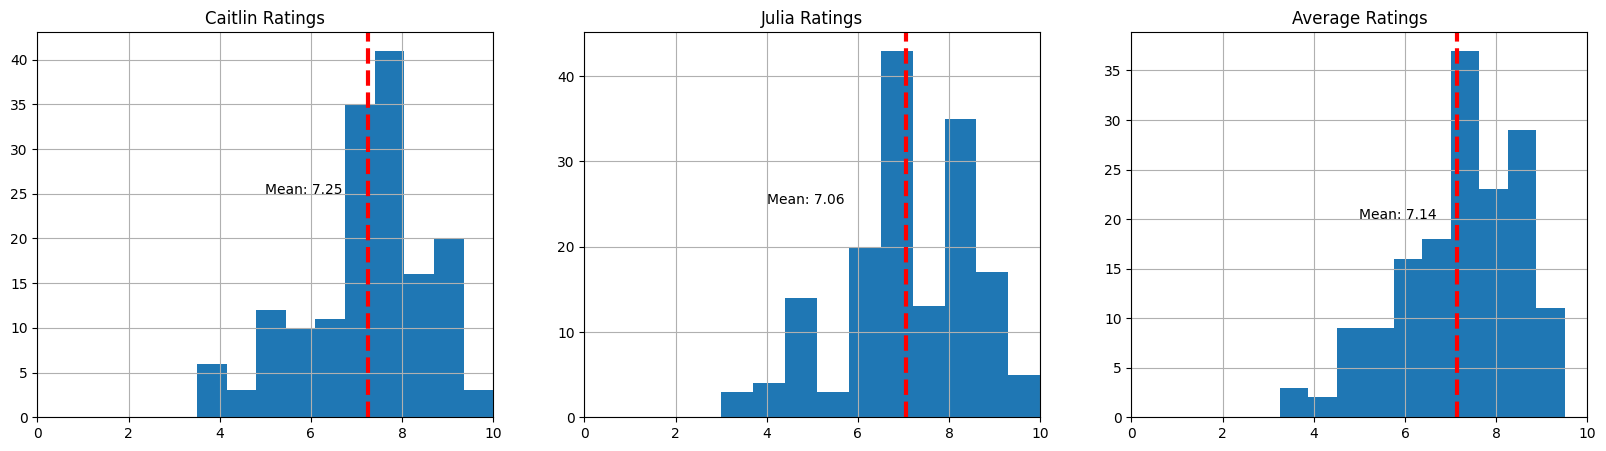

In [67]:
watched = doc.get_worksheet(1)
watch_history = watched.get_all_values()
mov = pd.DataFrame.from_records(watch_history)
mov = mov.iloc[1:]

# any blanks coerce to NaN, replace NaN with that column's average for the purposes of graphing
mov[2] = pd.to_numeric(mov[2], errors='coerce')
mov[3] = pd.to_numeric(mov[3], errors='coerce')
mov[4] = pd.to_numeric(mov[4], errors='coerce')
mov[2] = mov[2].fillna(mov[2].mean())
mov[3] = mov[3].fillna(mov[3].mean())
mov[4] = mov[4].fillna(mov[4].mean())

cc_ratings = mov[2].astype(float)
jm_ratings = mov[3].astype(float)
avg_ratings = mov[4].astype(float)

fig, axes = plt.subplots(1, 3, figsize = (20,5))
cc_ratings.hist(ax = axes[0])
jm_ratings.hist(ax = axes[1])
avg_ratings.hist(ax = axes[2])

axes[0].axvline(x=np.nanmean(cc_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[1].axvline(x=np.nanmean(jm_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[2].axvline(x=np.nanmean(avg_ratings), color='red', linestyle='--', linewidth=3, label='Avg')
axes[0].text(5, 25, 'Mean: {:.2f}'.format(np.nanmean(cc_ratings)))
axes[1].text(4, 25, 'Mean: {:.2f}'.format(np.nanmean(jm_ratings)))
axes[2].text(5, 20, 'Mean: {:.2f}'.format(np.nanmean(avg_ratings)))

axes[0].title.set_text('Caitlin Ratings')
axes[1].title.set_text('Julia Ratings')
axes[2].title.set_text('Average Ratings')

axes[0].set_xlim([0, 10])
axes[1].set_xlim([0, 10])
axes[2].set_xlim([0, 10])

In [68]:
import numpy as np
runtimes = pd.DataFrame(mov[8])
runtimes.head()
new = runtimes[8].str.split('h', n=1, expand=True)
hour = new[0]
min = new[1].str.split('m', n=1, expand=True)[0]
runtimes['minutes'] = hour.astype(int)*60 + min.astype(int)
tot_min = sum(runtimes['minutes'])
tot_hr = np.floor(sum(runtimes['minutes']) / 60 )
tot_day = tot_min / (60*24)
print("We've seen " + str(tot_min) + " minutes of movies together, which is " + str(tot_hr) + " hours and " + str(sum(runtimes['minutes'])%60) + " minutes or " + str(tot_day) + " days")

We've seen 17669 minutes of movies together, which is 294.0 hours and 29 minutes or 12.270138888888889 days


In [69]:
from typing import AbstractSet
actors = mov[12]
actors = actors.str.split("/")

counts = {}
for acts in actors:
  if acts == []:
    pass
  else:
    for actor1 in acts:
      if actor1 in counts.keys():
        counts[actor1] = counts[actor1] + 1
      else:
        counts[actor1] = 1

del counts['']
dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

{'Jennifer Lawrence': 5,
 'Ryan Gosling': 5,
 'Zendaya': 4,
 'Kate Hudson': 4,
 'Florence Pugh': 4,
 'Anne Hathaway': 4,
 'Sarah Michelle Gellar': 4,
 'James Marsden': 3,
 'Emma Stone': 3,
 'Aubrey Plaza': 3,
 'Jamie Lee Curtis': 3,
 'Andrew Garfield': 2,
 'Sandra Bullock': 2,
 'Maya Hawke': 2,
 'Bradley Cooper': 2,
 'Margot Robbie': 2,
 'Sam Claflin': 2,
 'Taylor Swift': 2,
 'Leonardo DiCaprio': 2,
 'Kristen Stewart': 2,
 'Taylor Lautner': 2,
 'Natasha Lyonne': 2,
 'Daisy Edgar-Jones': 2,
 'Dakota Johnson': 2,
 'Elisabeth Moss': 1,
 'Anne Hathaway, Matt Damon': 1,
 'Alison Brie': 1,
 'Nicholas Galitzine': 1,
 'Renee Rapp': 1,
 'Meryl Streep': 1,
 'Winona Ryder': 1,
 'Kristen Bell': 1,
 'Andy Samberg': 1,
 'Timothee Chalamet': 1,
 'Kiera Knightley': 1,
 'Eddie Murphy': 1,
 'Anne Hathaway, Nicholas Galitzine': 1,
 'Ke Huy Quan': 1}

## ML Experimentation

In [70]:
mov_x = mov[[5,6,7,10,11,14,15]].copy() # grab meaninful features
mov_x[1] = runtimes["minutes"] # add runtime in # of mins

mov_x.columns = ['Genre1', 'Genre2', 'Year','RT','IMDb','GFCC','GenreCluster','Min']
mov_x['Year'] = pd.to_numeric(mov_x['Year'])
mov_x['RT'] = mov_x['RT'].str.rstrip('%').astype('float') / 100.0
mov_x['IMDb'] = pd.to_numeric(mov_x['IMDb'])

caitlin_y = mov[[2]]
julia_y = mov[[3]]
both_y = mov[[4]]
mov_x.shape

(157, 8)

In [71]:
genre_cat = mov_x[['Genre1','Genre2']].stack().str.get_dummies().groupby(level=0).sum()
gfcc_cat = pd.get_dummies(mov_x[['GFCC']])
genre_cluster_cat = pd.get_dummies(mov_x[['GenreCluster']])
genre_cluster_cat.shape

(157, 6)

In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mov_x[['Year','RT','IMDb','Min']])
num_x = pd.DataFrame(scaler.transform(mov_x[['Year','RT','IMDb','Min']]), columns=['Year','RT','IMDb','Min'])
num_x.head()

,Year,RT,IMDb,Min
0,0.726027,0.431579,0.641509,0.533333
1,0.630137,0.810526,0.716981,0.171429
2,0.958904,0.926316,0.886792,0.695238
3,0.767123,0.326316,0.566038,0.466667
4,0.986301,0.957895,0.981132,0.619048


In [73]:
genre_cat.reset_index(drop=True, inplace=True)
num_x.reset_index(drop=True, inplace=True)
gfcc_cat.reset_index(drop=True, inplace=True)
genre_cluster_cat.reset_index(drop=True, inplace=True)
mov_x_all = pd.concat([genre_cat, num_x, gfcc_cat, genre_cluster_cat], axis=1)
mov_x_all = mov_x_all.dropna()
mov_x_all.shape


(157, 40)

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(mov_x_all,both_y,test_size=.2)
rf = RandomForestRegressor()
rf.fit(x_train, np.array(y_train))
predicted = rf.predict(x_test)
mean_squared_error(y_test, predicted)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


1.9844423828125002

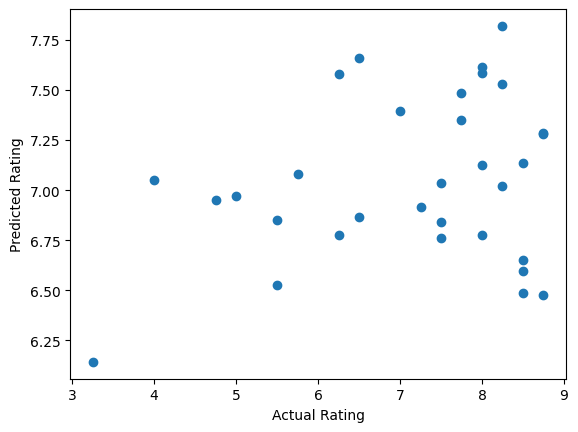

In [75]:
plt.scatter(y_test, predicted)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.show()